# Brain blood vessel clog loss
### Introduction

The data has come from https://www.drivendata.org/competitions/65/clog-loss-alzheimers-research/

Initial data was a set of videos of brain blood vessels, with the aim of detecting which blood vessels are stalled. As per the project website:

> 5.8 million Americans live with Alzheimer’s dementia, including 10% of all seniors 65 and older. Scientists at Cornell have discovered links between “stalls,” or clogged blood vessels in the brain, and Alzheimer’s. Stalls can reduce overall blood flow in the brain by 30%. The ability to prevent or remove stalls may transform how Alzheimer’s disease is treated.

> Stall Catchers is a citizen science project that crowdsources the analysis of Alzheimer’s disease research data provided by Cornell University’s Department of Biomedical Engineering. It resolves a pressing analytic bottleneck: for each hour of data collection it would take an entire week to analyze the results in the lab, which means an entire experimental dataset would take 6-12 months to analyze. Today, the Stall Catchers players are collectively analyzing data 5x faster than the lab while exceeding data quality requirements.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef

from sklearn.svm import SVC, LinearSVC


import keras
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Conv2D, Flatten, Dropout, BatchNormalization

Using TensorFlow backend.


### Load data from earlier pre-processing
Including label data, join labels to the features.

In [2]:
# Image Matrices
dataset= np.load("masked_images.npy")
print(dataset.shape)

# Image names
myNames= pd.read_csv("outdf.csv")
myNames['id']= myNames.filename.str.slice(0,6)
myNames= myNames.set_index('id')

print(myNames.head())
print(myNames.shape)

# All Labels
labels= pd.read_csv("../train_labels.csv")
print(labels.shape)
labels['id']= labels.filename.str.slice(0,6)
labels= labels.set_index('id')
labels= labels.drop('filename',axis=1)
print(labels.head())

# Join the labels into the df in the correct order so that we have correctly matched labels
data= myNames.join(labels, how='inner', on='id')
print(data.head())
print(data.shape)

# Save an output copy
data.to_csv("data_df.csv")

(1313, 44, 76)
        Unnamed: 0      filename
id                              
100109           0  100109_0.png
100289           1  100289_1.png
100588           2  100588_2.png
100750           3  100750_3.png
102393           4  102393_4.png
(1313, 2)
(573048, 2)
        stalled
id             
100000        0
100001        0
100002        0
100003        0
100004        0
        Unnamed: 0      filename  stalled
id                                       
100109           0  100109_0.png        1
100289           1  100289_1.png        1
100588           2  100588_2.png        0
100750           3  100750_3.png        0
102393           4  102393_4.png        0
(1313, 3)


### Reshape data matrices and split into training and test

In [3]:
train_data= dataset.reshape(1313, 44*76)
print(train_data.shape)

train_labels= data['stalled']
print(train_labels.shape)

X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size= 0.2)

(1313, 3344)
(1313,)


### Best accuracy from linear model

In [5]:
from sklearn.linear_model import SGDClassifier

# We set random_state=0 for reproducibility 
linear_classifier = SGDClassifier(random_state=0)

# Instantiate the GridSearchCV object and run the search
parameters = {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 
             'loss':['hinge','log'], 'penalty':['l1','l2']}
searcher = GridSearchCV(linear_classifier, parameters, cv=5)
searcher.fit(X_train, y_train)

# Report the best parameters and the corresponding score
print("Best CV params", searcher.best_params_)
print("Best CV accuracy", searcher.best_score_)
print("Test accuracy of best grid search hypers:", searcher.score(X_test, y_test))

Best CV params {'alpha': 0.01, 'loss': 'log', 'penalty': 'l2'}
Best CV accuracy 0.5980952380952381
Test accuracy of best grid search hypers: 0.5855513307984791


### Cross-validation with Support Vector Classifier

In [12]:
# Instantiate an SVM
svm = SVC()

# Instantiate the GridSearchCV object and run the search
parameters = {'C':[0.1, 1, 10], 'gamma':[0.00001, 0.0001, 0.001, 0.01, 0.1]}
searcher = GridSearchCV(svm, param_grid= parameters)
searcher.fit(X_train, y_train)

# Report the best parameters and the corresponding score
print("Best CV params", searcher.best_params_)
print("Best CV accuracy", searcher.best_score_)

# Report the test accuracy using these best parameters
print("Test accuracy of best grid search hypers:", searcher.score(X_test, y_test))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best CV params {'C': 1, 'gamma': 0.001}
Best CV accuracy 0.6257142857142857
Test accuracy of best grid search hypers: 0.6007604562737643


### Prepare data for Keras Model

In [25]:
n_cols = X_train.shape[1]
input_shape = (n_cols,)
print(input_shape)

y_train= to_categorical(y_train)
print(y_train.shape)

(3344,)
(1050, 2)


In [42]:
from keras.optimizers import Adam

model = Sequential()

model.add(Dense(1000, activation='relu', input_shape= input_shape))
model.add(Dropout(0.1))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(50, activation='relu'))
#model.add(Dropout(0.01))
model.add(Dense(2, activation='softmax'))

# Compile the model 
model.compile(optimizer=Adam(lr= 0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

early_stopping_monitor = EarlyStopping(patience= 4)
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

# Fit the model on a training set
his= model.fit(X_train, y_train, 
          validation_split= 0.3, 
          epochs=50, batch_size=30, callbacks=[early_stopping_monitor, mcp_save] )

Train on 735 samples, validate on 315 samples
Epoch 1/50
735/735 [==============================] - 1s 1ms/step - loss: 0.7212 - accuracy: 0.5837 - val_loss: 0.7031 - val_accuracy: 0.6254
Epoch 2/50
735/735 [==============================] - 1s 1ms/step - loss: 0.6101 - accuracy: 0.6871 - val_loss: 0.7640 - val_accuracy: 0.5524
Epoch 3/50
735/735 [==============================] - 1s 1ms/step - loss: 0.5697 - accuracy: 0.7102 - val_loss: 0.6808 - val_accuracy: 0.6254
Epoch 4/50
735/735 [==============================] - 1s 1ms/step - loss: 0.5071 - accuracy: 0.7442 - val_loss: 0.7557 - val_accuracy: 0.6222
Epoch 5/50
735/735 [==============================] - 1s 1ms/step - loss: 0.4629 - accuracy: 0.8054 - val_loss: 0.8457 - val_accuracy: 0.6317
Epoch 6/50
735/735 [==============================] - 1s 1ms/step - loss: 0.3668 - accuracy: 0.8259 - val_loss: 0.9154 - val_accuracy: 0.5841
Epoch 7/50
735/735 [==============================] - 1s 1ms/step - loss: 0.3440 - accuracy: 0.8463 - 

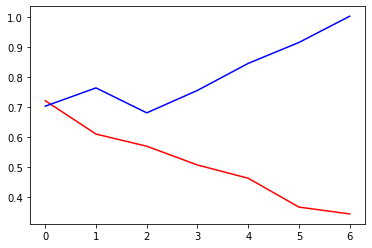

In [43]:
plt.plot(his.history['loss'], 'r', his.history['val_loss'], 'b')

### Output predictions to an external file

In [47]:
preds= model.predict(X_train)
predsdf= pd.DataFrame(preds)
predsdf.to_csv("preds.df")